In [1]:
import pandas as pd
import csv
import re
from datetime import datetime
from functools import reduce
import matplotlib.pyplot as plt

In [2]:
def parseElasticSearchDate(timestamp):
    return datetime.strptime(timestamp, '%b %d, %Y @ %H:%M:%S.%f')

In [3]:
def csvToList(filename, valueKey, timestamp_key="@timestamp"):
    csvList = []
    with open(filename, 'r') as data:  
        for line in csv.DictReader(data):
            timestamp = parseElasticSearchDate(line[timestamp_key])
            csvList.append((timestamp, line[valueKey]))
    return csvList

In [4]:
def closestDatetime(metricList, date):
    return float(min(metricList, key=lambda x: abs(x[0] - date))[1][:-1])

In [5]:
def getResultPath(experiment, sessionSize, approach, metric):
    return '%s/%s_Participants_Per_Session/%s/%s_%s_%s.csv' %  (
                        experiment, sessionSize, approach, sessionSize, approach, metric)

In [6]:
def generateChart(dfs, ax, title, ylabel):
    df = reduce(
            lambda left,right: left.merge(right, how= "right" if len(right.index) > len(left.index) else "left")
        , dfs)
    df = df.drop(columns=['Users']) 
    ax_df = df.plot.line(title=title, ax = ax)
    ax_df.set_ylabel(ylabel)  
    ax_df.set_xlabel("Number of users")
    return ax_df

In [7]:
def extractMetrics(sessionSize, approach, approach_name, experiment, 
                   cpu_label="CPU", mem_label="Mem", joined_label="Joined"):
    cpu_path = getResultPath(experiment, sessionSize, approach, cpu_label)
    mem_path = getResultPath(experiment, sessionSize, approach, mem_label)
    joined_path = getResultPath(experiment, sessionSize, approach, joined_label)
    cpuList = csvToList(cpu_path, 'system.cpu.total.norm.pct')
    memList = csvToList(mem_path, 'system.memory.used.pct')

    unorderJoinedList = []
    with open(joined_path, 'r') as data:

        orderedJoinedList = sorted(
            map(lambda l: parseElasticSearchDate(l["timestamp"]), csv.DictReader(data))
        )

    count = 0

    data = {
        "users": [],
        "cpu": [],
        "mem": []
    }

    for userJoinedTimeStamp in orderedJoinedList:
        count = count + 1
        closestCpuMetric = closestDatetime(cpuList, userJoinedTimeStamp)
        closestMemMetric = closestDatetime(memList, userJoinedTimeStamp)
        data["users"].append(count)
        data["cpu"].append(closestCpuMetric)
        data["mem"].append(closestMemMetric)

    cpu_data = {}
    cpu_data["Users"] = data["users"]
    cpu_data[approach_name] = data["cpu"]

    mem_data = {}
    mem_data["Users"] = data["users"]
    mem_data[approach_name] = data["mem"]
    
    return cpu_data, mem_data

In [8]:
def generateTable(experiment, approaches_map, joined_label="Joined"):
    table = []
    max_sessions_map = {}
    max_users_map = {}

    for sessionSize in sessionSizes:    

        for approach, approach_name in approaches_map.items():

            joined_path = getResultPath(experiment, sessionSize, approach, joined_label)
            with open(joined_path, 'r') as data:  
                lines = list(csv.DictReader(data))

            # Fill table
            numUsers = len(lines)
            numSessions = int(numUsers/int(sessionSize))
            table.append([sessionSize, approach_name, numSessions, "%d (%d)"%(numSessions*int(sessionSize),numUsers)])

            if approach_name not in max_sessions_map:
                max_sessions_map[approach_name] = []

            if approach_name not in max_users_map:
                max_users_map[approach_name] = []

            max_sessions_map[approach_name].append(numSessions)
            max_users_map[approach_name].append(numUsers)

    df = pd.DataFrame(table)
    df.columns =['Session size', 'Testing strategies', 'Max complete Sessions', 'Max users']
    df = df.set_index('Session size')
    df.to_csv("%s/results/results.csv"%experiment)
    return df, max_users_map, max_sessions_map

## 1. Preliminary Results

### 1.1 Generate graphics of CPU/Mem for each seasionSize and approach

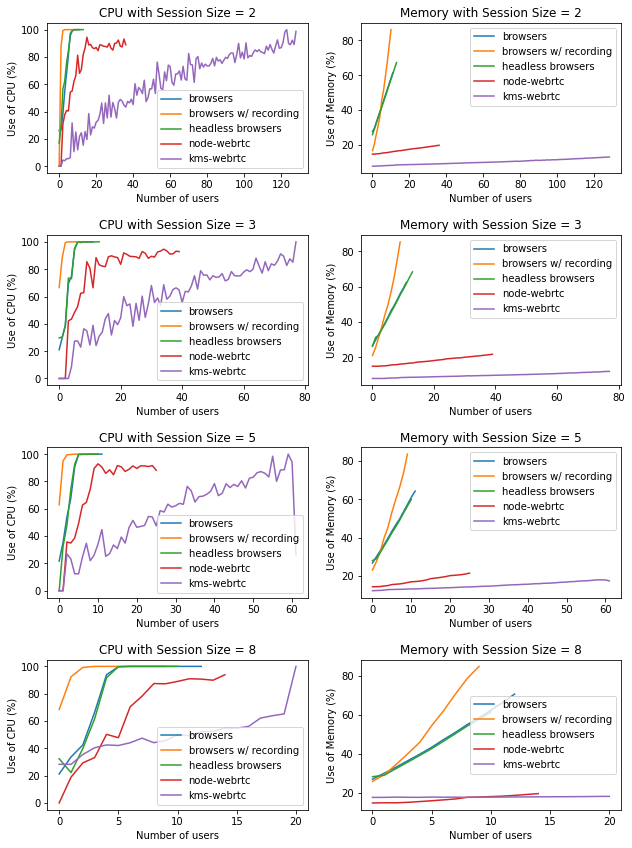

In [9]:
sessionSizes = ["2", "3", "5", "8"]

approaches_map = {
    "SeleniumWithoutRecording" : "browsers",
    "SeleniumWithRecording" : "browsers w/ recording",
    "headless browsers" : "headless browsers",
    "node-webrtc" : "node-webrtc",
    "kms-webrtc" : "kms-webrtc"
}

figure, axes = plt.subplots(4, 2)
figure.set_size_inches(9, 12)
row = 0

for sessionSize in sessionSizes:
    
    cpu_dfs = []
    mem_dfs = []
    
    for approach, approach_name in approaches_map.items():
        
        cpu_data, mem_data = extractMetrics(sessionSize, approach, approach_name, "Preliminar")

        cpu_dfs.append(pd.DataFrame(cpu_data))
        
        mem_dfs.append(pd.DataFrame(mem_data))
    
    # Generate CPU Chart    
    generateChart(cpu_dfs, axes[row, 0], "CPU with Session Size = %s"%sessionSize, "Use of CPU (%)")
    
    # Generate Mem
    generateChart(mem_dfs, axes[row, 1], "Memory with Session Size = %s"%sessionSize, "Use of Memory (%)")
    
    row = row + 1

plt.rcParams.update({'font.size': 10 })
figure.tight_layout(pad=1.5)
figure.savefig("Preliminar/images/AllChartsInOne.pdf")

### 1.2 Generate table of results (Max users and Max complete Sessions per Strategy/SessionSize)

In [10]:
df, max_users_map, max_sessions_map = generateTable("Preliminar", approaches_map)
df

,Testing strategies,Max complete Sessions,Max users
Session size,,,
2,browsers,6,12 (12)
2,browsers w/ recording,5,10 (11)
2,headless browsers,7,14 (14)
2,node-webrtc,18,36 (37)
2,kms-webrtc,64,128 (129)
3,browsers,4,12 (12)
3,browsers w/ recording,3,9 (10)
3,headless browsers,4,12 (14)
3,node-webrtc,13,39 (40)


### 1.4 Generate comparative graphic: Number of Users per Strategy and SessionSize

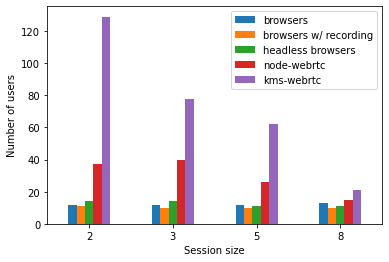

In [11]:
df = pd.DataFrame(max_users_map, index=sessionSizes)
ax = df.plot.bar(rot=0)
ax.set_ylabel("Number of users")
ax.set_xlabel("Session size")
ax.figure.savefig("Preliminar/images/UserComparation.pdf")

### 1.5 Generate comparative graphic: Number of Sessions per Strategy and SessionSize

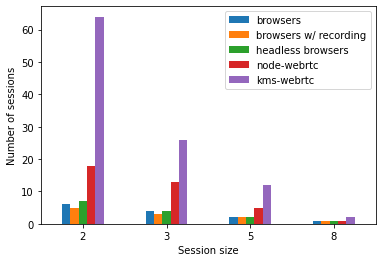

In [12]:
df = pd.DataFrame(max_sessions_map, index=sessionSizes)
ax = df.plot.bar(rot=0)
ax.set_ylabel("Number of sessions")
ax.set_xlabel("Session size")
ax.figure.savefig("Preliminar/images/SessionComparation.pdf")

## 2 Final experiment

### 2.1 Generate graphics of CPU/Mem for each seasionSize and approach

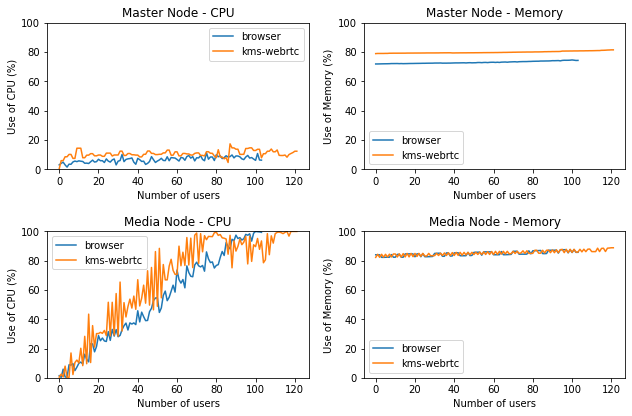

In [13]:
sessionSizes = ["5"]
approaches_map_final = {
    "browser": "browser",
    "kms-webrtc" : "kms-webrtc"
}

figure, axes = plt.subplots(2, 2)
figure.set_size_inches(9, 6)
row = 0

for sessionSize in sessionSizes:
    
    cpu_masternode_dfs = []
    mem_masternode_dfs = []
    cpu_medianode_dfs = []
    mem_medianode_dfs = []
    
    for approach, approach_name in approaches_map_final.items():
        
        # Master Node
        
        cpu_data_masternode, mem_data_masternode = extractMetrics(sessionSize, approach, approach_name, "Final",
                                            cpu_label="MASTERNODE_CPU_Final", 
                                            mem_label="MASTERNODE_Mem_Final", 
                                            joined_label="Joined_Final")

        cpu_masternode_dfs.append(pd.DataFrame(cpu_data_masternode))
        
        mem_masternode_dfs.append(pd.DataFrame(mem_data_masternode))
        
        # Media Nodes
        
        cpu_data_medianode, mem_data_medianode = extractMetrics(sessionSize, approach, approach_name, "Final",
                                            cpu_label="MEDIANODE_CPU_Final", 
                                            mem_label="MEDIANODE_Mem_Final", 
                                            joined_label="Joined_Final")

        cpu_medianode_dfs.append(pd.DataFrame(cpu_data_medianode))
        
        mem_medianode_dfs.append(pd.DataFrame(mem_data_medianode))
    
    # Generate CPU Chart (MasterNode)
    axes[row, 0].set_ylim(0,100)
    generateChart(cpu_masternode_dfs, axes[row, 0], "Master Node - CPU", "Use of CPU (%)")
    
    # Generate Mem (MasterNode) 
    axes[row, 1].set_ylim(0,100)
    generateChart(mem_masternode_dfs, axes[row, 1], "Master Node - Memory", "Use of Memory (%)")
    
    
    row = row + 1
    
    # Generate CPU Chart (MediaNode) 
    axes[row, 0].set_ylim(0,100)
    generateChart(cpu_medianode_dfs, axes[row, 0], "Media Node - CPU", "Use of CPU (%)")
    
    # Generate Mem (MediaNode)
    axes[row, 1].set_ylim(0,100)
    generateChart(mem_medianode_dfs, axes[row, 1], "Media Node - Memory", "Use of Memory (%)")
    
    
plt.rcParams.update({'font.size': 10 })
figure.tight_layout(pad=1.5)
figure.savefig("Final/images/AllChartsInOneFinal.pdf")

###  2.2 Generate table of results (Max users and Max complete Sessions per Strategy/SessionSize)

In [14]:
df, _, _ = generateTable("Final", approaches_map_final, joined_label="Joined_Final")
df

,Testing strategies,Max complete Sessions,Max users
Session size,,,
5,browser,20,100 (104)
5,kms-webrtc,24,120 (122)
